# Análise COVID-19 no Brasil 
#### Instruções baseadas na formação Cientista de Dados na DIO

##### - Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px 
import plotly.graph_objects as go 

In [2]:
# Importando arquivo para um DataFrame
df = pd.read_csv('dados/WHO-COVID-19-global-data.csv', parse_dates=['Date_reported'])

df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


####  - Selecionando apenas: Brasil e número de casos > 0

In [3]:
dfBrasil = df[(df['Country'] == 'Brazil') & (df['Cumulative_cases'] > 0)]

dfBrasil.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
31163,2020-02-27,BR,Brazil,AMRO,1,1,0,0
31164,2020-02-28,BR,Brazil,AMRO,0,1,0,0
31165,2020-02-29,BR,Brazil,AMRO,0,1,0,0
31166,2020-03-01,BR,Brazil,AMRO,0,1,0,0
31167,2020-03-02,BR,Brazil,AMRO,1,2,0,0


#### - Casos confirmados

In [4]:
px.line(dfBrasil, 'Date_reported', 'Cumulative_cases', title='Casos confirmados no Brasil')

#### - Casos confirmados diários

In [5]:
px.line(dfBrasil, 'Date_reported', 'New_cases', title='Casos confirmados de covid-19 no Brasil diariamente')

#### - Mortes confirmadas no período

In [6]:
px.line(dfBrasil, 'Date_reported', 'Cumulative_deaths', title='Evolução das mortes por covid-19 no Brasil (2020-2023)')

#### - Evolução das mortes diária no Brasil (2020-2023)

In [7]:
px.line(dfBrasil, 'Date_reported', 'New_deaths', title='Evolução das mortes diária no Brasil por covid-19 (2020-2023)')

#### - Taxa de crescimento do número de casos (2020-2023)

In [8]:
def taxa_crescimento(data, variable, data_inicio = None, data_fim = None):

    if data_inicio == None:
        data_inicio = data.Date_reported.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)

    if data_fim == None:
        data_fim = data.Date_reported.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)

    n = (data_fim - data_inicio).days

    passado = data.loc[data.Date_reported == data_inicio, variable].values[0]
    presente = data.loc[data.Date_reported == data_fim, variable].values[0]

    return ((presente/passado)**(1/n) - 1) * 100

In [9]:
taxa_crescimento(dfBrasil, 'Cumulative_cases')

1.664458819971748

#### - Taxa de crescimento diário do número de casos (2020-2023)

In [10]:
def taxa_crescimento_diario(data, variable, data_inicio = None):

    if data_inicio == None:
        data_inicio = data.Date_reported.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)

    data_fim = data.Date_reported.max()
    
    n = (data_fim - data_inicio).days

    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x - 1]) / data[variable].iloc[x - 1],
        range(1, n + 1)
    ))

    return np.array(taxas) * 100

In [11]:
tx_diaria = taxa_crescimento_diario(dfBrasil, 'Cumulative_cases')

In [12]:
primeiro_dia = dfBrasil.Date_reported.loc[dfBrasil.Cumulative_cases > 0].min()

px.line(x = pd.date_range(primeiro_dia, dfBrasil.Date_reported.max())[1:],
     y = tx_diaria, title='Taxa de crescimento (%) dos casos diário no Brasil por covid-19 (2020-2023)')

#### - Predições

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [14]:
confirmados = dfBrasil['Cumulative_cases']
confirmados.index = dfBrasil['Date_reported']

confirmados

Date_reported
2020-02-27           1
2020-02-28           1
2020-02-29           1
2020-03-01           1
2020-03-02           2
                ...   
2023-01-13    36578865
2023-01-14    36597935
2023-01-15    36597935
2023-01-16    36597935
2023-01-17    36597935
Name: Cumulative_cases, Length: 1056, dtype: int64

In [15]:
modelo = seasonal_decompose(confirmados)

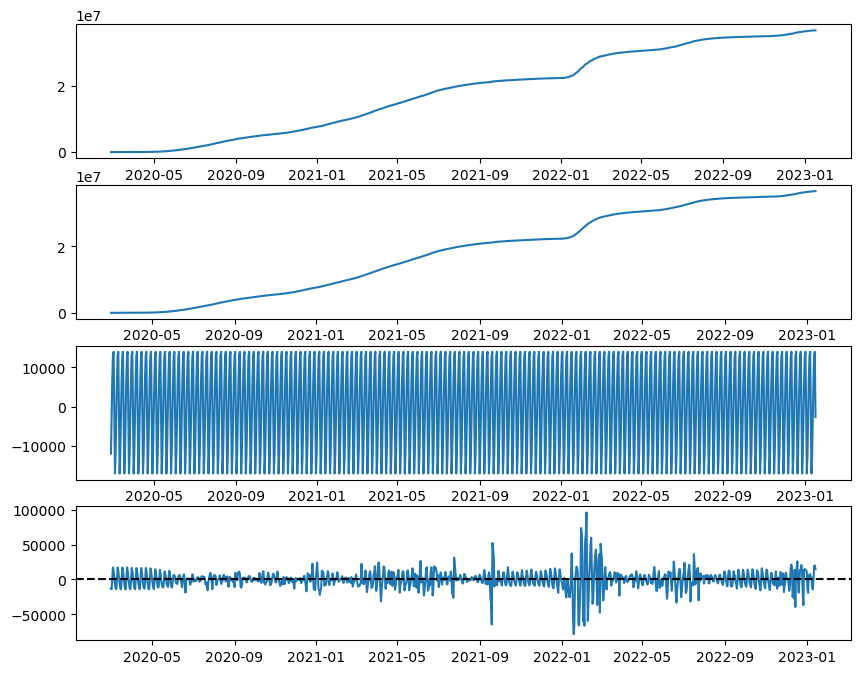

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10, 8))

ax1.plot(modelo.observed)
ax2.plot(modelo.trend)
ax3.plot(modelo.seasonal)
ax4.plot(confirmados.index, modelo.resid)
ax4.axhline(0, linestyle = 'dashed', c = 'black')

plt.show()

#### - ARIMA

In [17]:
from pmdarima.arima import auto_arima

In [18]:
modelo = auto_arima(confirmados)

In [19]:
fig = go.Figure(go.Scatter(
    x = confirmados.index, y = confirmados, name = 'Observados'
))

fig.add_trace(go.Scatter(
    x = confirmados.index, y = modelo.predict_in_sample(), name = 'Preditos'
))

fig.add_trace(go.Scatter(
    x = pd.date_range('2023-01-18', '2023-07-18'), y = modelo.predict(181), name = 'Forecast'
))

fig.update_layout(title = 'Previsão de casos confirmados no Brasil para os próximos 6 meses')